In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
DATASET_DIR = "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset"


In [9]:
import os

print(os.listdir("/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset"))


['IQ-OTH_NCCD lung cancer dataset.txt', 'Normal cases', 'Bengin cases', 'Malignant cases']


In [10]:
for cls in ["Bengin cases", "Malignant cases", "Normal cases"]:
    print(cls, ":", len(os.listdir(f"{DATASET_DIR}/{cls}")))


Bengin cases : 120
Malignant cases : 561
Normal cases : 416


In [11]:

iq_dataset_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'
chest_ct_path = '/content/drive/MyDrive/Data'

# 3. Check if files exist
print(f"Checking IQ Dataset: {os.path.exists(iq_dataset_path)}")
print(f"Checking Chest CT Dataset: {os.path.exists(chest_ct_path)}")

Checking IQ Dataset: True
Checking Chest CT Dataset: True


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- PART 1: INCEPTIONNEXT BLOCK (Convolutional Features) ---
# Based on Figure 4 of the paper
class InceptionDWConv2d(nn.Module):
    def __init__(self, in_channels, square_kernel_size=3, band_kernel_size=11, branch_ratio=0.125):
        super().__init__()

        # Calculate channels for each branch based on the ratio (usually 1/8th per branch)
        gc = int(in_channels * branch_ratio)
        self.dwconv_hw = nn.Conv2d(gc, gc, square_kernel_size, padding=square_kernel_size//2, groups=gc)
        self.dwconv_w = nn.Conv2d(gc, gc, (1, band_kernel_size), padding=(0, band_kernel_size//2), groups=gc)
        self.dwconv_h = nn.Conv2d(gc, gc, (band_kernel_size, 1), padding=(band_kernel_size//2, 0), groups=gc)
        self.split_indexes = (in_channels - 3 * gc, gc, gc, gc)

    def forward(self, x):
        # Split input into 4 parts: Identity, 3x3 conv, 1x11 conv, 11x1 conv
        x_id, x_hw, x_w, x_h = torch.split(x, self.split_indexes, dim=1)

        # Apply convolutions
        return torch.cat((
            x_id,
            self.dwconv_hw(x_hw),
            self.dwconv_w(x_w),
            self.dwconv_h(x_h)
        ), dim=1)

class InceptionNextBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = InceptionDWConv2d(dim)
        self.norm = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # Pointwise expansion
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim) # Pointwise reduction

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C) for Linear layers
        x = self.norm(input.permute(0, 2, 3, 1)) # Normalize the input, not the conv output (Pre-Norm)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # Back to (N, C, H, W)

        return input + x

# --- PART 2: ATTENTION BLOCK (Simplified Max-SA) ---
# Based on Figure 3 (Grid/Block Attention)
class SimpleAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    def forward(self, x):
        # x shape: (N, C, H, W)
        n, c, h, w = x.shape
        x_flat = x.flatten(2).transpose(1, 2) # (N, H*W, C)

        # Self-Attention
        x_norm = self.norm1(x_flat)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x_flat = x_flat + attn_out

        # MLP
        x_norm = self.norm2(x_flat)
        mlp_out = self.mlp(x_norm)
        x_flat = x_flat + mlp_out

        return x_flat.transpose(1, 2).reshape(n, c, h, w)

# --- PART 3: THE FULL HYBRID MODEL ---
class HybridLungCancerModel(nn.Module):
    def __init__(self, num_classes=3): # 3 classes for IQ dataset, 4 for Chest CT
        super().__init__()

        # Stage 0: Stem (Initial Conv)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Stage 1 & 2: InceptionNeXt Blocks (Convolutional focus)
        self.stage1 = nn.Sequential(
            InceptionNextBlock(64),
            InceptionNextBlock(64)
        )
        self.downsample1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.stage2 = nn.Sequential(
            InceptionNextBlock(128),
            InceptionNextBlock(128)
        )
        self.downsample2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # Stage 3: Hybrid Block (Convs + Attention)
        self.stage3 = nn.Sequential(
            InceptionNextBlock(256),
            SimpleAttentionBlock(256) # Adding Attention here
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Head: Classifier
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.downsample1(x)
        x = self.stage2(x)
        x = self.downsample2(x)
        x = self.stage3(x)

        x = self.pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

# Check if it runs
model = HybridLungCancerModel(num_classes=3)
print(f"Model Created Successfully! Total Params: {sum(p.numel() for p in model.parameters())/1e6:.2f} Million")

Model Created Successfully! Total Params: 2.03 Million


Counting classes for IQ-OTH/NCCD Training Set...
--- IQ-OTH/NCCD Training Set ---
Bengin cases: 80 (10.4%)
Malignant cases: 404 (52.7%)
Normal cases: 283 (36.9%)
--------------------


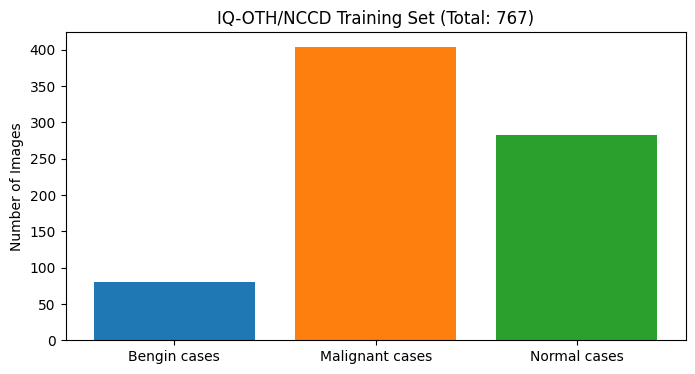

Counting classes for Chest CT Training Set...
--- Chest CT Training Set ---
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195 (31.8%)
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 (18.8%)
normal: 148 (24.1%)
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 (25.3%)
--------------------


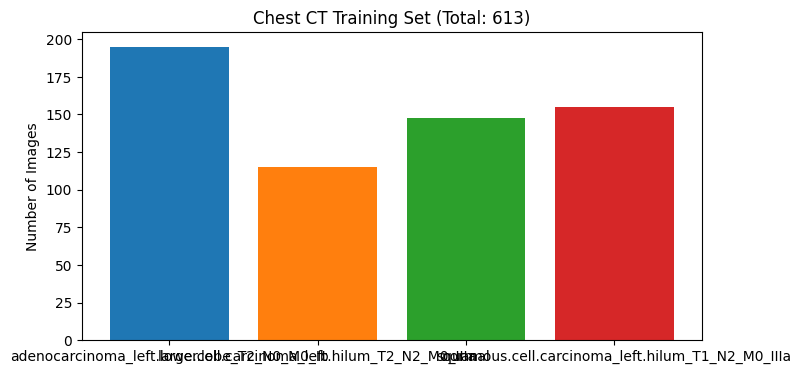

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(loader, class_names, title="Dataset Distribution"):
    # Initialize counters
    class_counts = {name: 0 for name in class_names}

    # Iterate through loader to count (works for any dataset type)
    print(f"Counting classes for {title}...")
    for _, labels in loader:
        for label in labels:
            class_name = class_names[label.item()]
            class_counts[class_name] += 1

    # Prepare data for plotting
    names = list(class_counts.keys())
    values = list(class_counts.values())
    total = sum(values)

    # Print raw numbers
    print(f"--- {title} ---")
    for name, count in class_counts.items():
        percent = (count / total) * 100 if total > 0 else 0
        print(f"{name}: {count} ({percent:.1f}%)")
    print("-" * 20)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title(f"{title} (Total: {total})")
    plt.ylabel('Number of Images')
    plt.show()
    return values # Return counts for weight calculation

# --- EXECUTE CHECK ---

# 1. Check IQ Dataset (Malignant, Benign, Normal)
# We need to get class names from the original ImageFolder
iq_class_names = iq_train.dataset.subset.dataset.classes
iq_counts = plot_class_distribution(iq_train, iq_class_names, "IQ-OTH/NCCD Training Set")

# 2. Check Chest CT Dataset (Adeno, Large, Normal, Squamous)
chest_class_names = chest_train.dataset.classes
chest_counts = plot_class_distribution(chest_train, chest_class_names, "Chest CT Training Set")

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# Define your paths again just to be safe (Update these if they changed!)
iq_dataset_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'
chest_ct_path = '/content/drive/MyDrive/Data'

BATCH_SIZE = 32
IMG_SIZE = 224

# Define Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 1. Load IQ Dataset with Split
def get_iq_dataloaders(root_path):
    full_dataset = datasets.ImageFolder(root=root_path, transform=None)
    train_size = int(0.70 * len(full_dataset))
    val_size = int(0.10 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

    # Apply transforms using a wrapper
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y
        def __len__(self):
            return len(self.subset)

    train_set = TransformedSubset(train_data, transform=train_transforms)
    val_set = TransformedSubset(val_data, transform=val_test_transforms)
    test_set = TransformedSubset(test_data, transform=val_test_transforms)

    return (DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True),
            DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False),
            DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False),
            train_set) # Returning train_set to access classes later

# 2. Load Chest CT Dataset
def get_chest_dataloaders(root_path):
    train_dir = os.path.join(root_path, 'train')
    test_dir = os.path.join(root_path, 'test')
    val_dir = os.path.join(root_path, 'valid')

    if not os.path.exists(val_dir) and os.path.exists(os.path.join(root_path, 'validation')):
         val_dir = os.path.join(root_path, 'validation')

    train_set = datasets.ImageFolder(root=train_dir, transform=train_transforms)
    test_set = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)
    val_set = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)

    return (DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True),
            DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False),
            DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False),
            train_set)

# Execute Loading
print("Loading IQ Dataset...")
iq_train, iq_val, iq_test, iq_train_set = get_iq_dataloaders(iq_dataset_path)

print("Loading Chest CT Dataset...")
chest_train, chest_val, chest_test, chest_train_set = get_chest_dataloaders(chest_ct_path)

print("Data Loaded Successfully!")

Loading IQ Dataset...
Loading Chest CT Dataset...
Data Loaded Successfully!


In [16]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

def plot_class_distribution(loader, class_names, title="Dataset Distribution"):
    class_counts = {name: 0 for name in class_names}

    print(f"Counting classes for {title}...")
    for _, labels in loader:
        for label in labels:
            class_name = class_names[label.item()]
            class_counts[class_name] += 1

    names = list(class_counts.keys())
    values = list(class_counts.values())
    total = sum(values)

    print(f"--- {title} ---")
    for name, count in class_counts.items():
        percent = (count / total) * 100 if total > 0 else 0
        print(f"{name}: {count} ({percent:.1f}%)")

    # Return counts ordered by class index
    return [class_counts[name] for name in class_names]

# 1. Get Class Names
# For IQ dataset, we access the underlying dataset inside the subset
iq_classes = iq_train_set.subset.dataset.classes
chest_classes = chest_train_set.classes

# 2. Count & Plot
iq_counts = plot_class_distribution(iq_train, iq_classes, "IQ-OTH/NCCD")
chest_counts = plot_class_distribution(chest_train, chest_classes, "Chest CT")

# 3. Calculate Weighted Loss for IQ Dataset
total_samples = sum(iq_counts)
num_classes = len(iq_counts)
class_weights = []

for count in iq_counts:
    # Avoid division by zero if a count is 0 (though unlikely here)
    weight = total_samples / (num_classes * count) if count > 0 else 1.0
    class_weights.append(weight)

print(f"\nRecommended Class Weights for IQ: {class_weights}")

# Convert to Tensor for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# This is the criterion you will use in training
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Criterion created with Class Weights!")

Counting classes for IQ-OTH/NCCD...
--- IQ-OTH/NCCD ---
Bengin cases: 80 (10.4%)
Malignant cases: 404 (52.7%)
Normal cases: 283 (36.9%)
Counting classes for Chest CT...
--- Chest CT ---
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195 (31.8%)
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 (18.8%)
normal: 148 (24.1%)
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 (25.3%)

Recommended Class Weights for IQ: [3.1958333333333333, 0.6328382838283828, 0.9034157832744405]
Criterion created with Class Weights!


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- PART 1: INCEPTIONNEXT BLOCK (Fixed) ---
class InceptionDWConv2d(nn.Module):
    def __init__(self, in_channels, square_kernel_size=3, band_kernel_size=11, branch_ratio=0.125):
        super().__init__()
        gc = int(in_channels * branch_ratio)
        self.dwconv_hw = nn.Conv2d(gc, gc, square_kernel_size, padding=square_kernel_size//2, groups=gc)
        self.dwconv_w = nn.Conv2d(gc, gc, (1, band_kernel_size), padding=(0, band_kernel_size//2), groups=gc)
        self.dwconv_h = nn.Conv2d(gc, gc, (band_kernel_size, 1), padding=(band_kernel_size//2, 0), groups=gc)
        self.split_indexes = (in_channels - 3 * gc, gc, gc, gc)

    def forward(self, x):
        x_id, x_hw, x_w, x_h = torch.split(x, self.split_indexes, dim=1)
        return torch.cat((
            x_id,
            self.dwconv_hw(x_hw),
            self.dwconv_w(x_w),
            self.dwconv_h(x_h)
        ), dim=1)

class InceptionNextBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = InceptionDWConv2d(dim)
        # CHANGED: Use LayerNorm instead of BatchNorm2d for Channel-Last compatibility
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)          # Apply Norm to the HW C tensor
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        return input + x

# --- PART 2: ATTENTION BLOCK ---
class SimpleAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    def forward(self, x):
        n, c, h, w = x.shape
        x_flat = x.flatten(2).transpose(1, 2)

        x_norm = self.norm1(x_flat)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x_flat = x_flat + attn_out

        x_norm = self.norm2(x_flat)
        mlp_out = self.mlp(x_norm)
        x_flat = x_flat + mlp_out

        return x_flat.transpose(1, 2).reshape(n, c, h, w)

# --- PART 3: THE FULL HYBRID MODEL ---
class HybridLungCancerModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = nn.Sequential(InceptionNextBlock(64), InceptionNextBlock(64))
        self.downsample1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.stage2 = nn.Sequential(InceptionNextBlock(128), InceptionNextBlock(128))
        self.downsample2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.stage3 = nn.Sequential(InceptionNextBlock(256), SimpleAttentionBlock(256))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.downsample1(x)
        x = self.stage2(x)
        x = self.downsample2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

# Re-instantiate to apply changes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridLungCancerModel(num_classes=3).to(DEVICE)
print("Model Updated and Re-initialized!")

Model Updated and Re-initialized!


In [18]:
import torch
if torch.cuda.is_available():
    print(f"Success! GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print("Error: Still on CPU. Try switching runtime again.")

Success! GPU Detected: Tesla T4


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- PART 1: INCEPTIONNEXT BLOCK (Fixed with LayerNorm) ---
class InceptionDWConv2d(nn.Module):
    def __init__(self, in_channels, square_kernel_size=3, band_kernel_size=11, branch_ratio=0.125):
        super().__init__()
        gc = int(in_channels * branch_ratio)
        self.dwconv_hw = nn.Conv2d(gc, gc, square_kernel_size, padding=square_kernel_size//2, groups=gc)
        self.dwconv_w = nn.Conv2d(gc, gc, (1, band_kernel_size), padding=(0, band_kernel_size//2), groups=gc)
        self.dwconv_h = nn.Conv2d(gc, gc, (band_kernel_size, 1), padding=(band_kernel_size//2, 0), groups=gc)
        self.split_indexes = (in_channels - 3 * gc, gc, gc, gc)

    def forward(self, x):
        x_id, x_hw, x_w, x_h = torch.split(x, self.split_indexes, dim=1)
        return torch.cat((
            x_id,
            self.dwconv_hw(x_hw),
            self.dwconv_w(x_w),
            self.dwconv_h(x_h)
        ), dim=1)

class InceptionNextBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = InceptionDWConv2d(dim)
        # Using LayerNorm for stability with channel-last permutation
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)
        return input + x

# --- PART 2: ATTENTION BLOCK ---
class SimpleAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    def forward(self, x):
        n, c, h, w = x.shape
        x_flat = x.flatten(2).transpose(1, 2)

        x_norm = self.norm1(x_flat)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x_flat = x_flat + attn_out

        x_norm = self.norm2(x_flat)
        mlp_out = self.mlp(x_norm)
        x_flat = x_flat + mlp_out

        return x_flat.transpose(1, 2).reshape(n, c, h, w)

# --- PART 3: THE FULL HYBRID MODEL ---
class HybridLungCancerModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = nn.Sequential(InceptionNextBlock(64), InceptionNextBlock(64))
        self.downsample1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.stage2 = nn.Sequential(InceptionNextBlock(128), InceptionNextBlock(128))
        self.downsample2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.stage3 = nn.Sequential(InceptionNextBlock(256), SimpleAttentionBlock(256))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.downsample1(x)
        x = self.stage2(x)
        x = self.downsample2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

print("Model Class Defined Successfully!")

Model Class Defined Successfully!


--- Starting Full 300-Epoch Training (IQ-OTH/NCCD) ---
Device: cuda
-> Using Weighted Loss.


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/300 | Train Loss: 1.0887 | Val Acc: 47.71% -> BEST Saved!


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/300 | Train Loss: 1.0355 | Val Acc: 52.29% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/300 | Train Loss: 0.8311 | Val Acc: 57.80% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/300 | Train Loss: 0.7939 | Val Acc: 46.79% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25/300 | Train Loss: 0.7537 | Val Acc: 65.14% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30/300 | Train Loss: 0.6551 | Val Acc: 71.56% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35/300 | Train Loss: 0.7243 | Val Acc: 69.72% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40/300 | Train Loss: 0.6270 | Val Acc: 69.72% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45/300 | Train Loss: 0.5104 | Val Acc: 69.72% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

   [Checkpoint Saved at Epoch 50]
Epoch 50/300 | Train Loss: 0.4988 | Val Acc: 77.06% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 55/300 | Train Loss: 0.5160 | Val Acc: 77.06% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 60/300 | Train Loss: 0.4948 | Val Acc: 66.06% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 65/300 | Train Loss: 0.5140 | Val Acc: 77.06% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 70/300 | Train Loss: 0.4755 | Val Acc: 59.63% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 75/300 | Train Loss: 0.4054 | Val Acc: 81.65% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 80/300 | Train Loss: 0.2705 | Val Acc: 83.49% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 85/300 | Train Loss: 0.2495 | Val Acc: 83.49% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 90/300 | Train Loss: 0.2524 | Val Acc: 82.57% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 95/300 | Train Loss: 0.2138 | Val Acc: 88.99% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

   [Checkpoint Saved at Epoch 100]
Epoch 100/300 | Train Loss: 0.2212 | Val Acc: 83.49% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 105/300 | Train Loss: 0.2080 | Val Acc: 88.99% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 110/300 | Train Loss: 0.1861 | Val Acc: 89.91% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 115/300 | Train Loss: 0.1644 | Val Acc: 90.83% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 120/300 | Train Loss: 0.1609 | Val Acc: 91.74% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 125/300 | Train Loss: 0.1356 | Val Acc: 92.66% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 130/300 | Train Loss: 0.1688 | Val Acc: 90.83% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 135/300 | Train Loss: 0.1460 | Val Acc: 91.74% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 140/300 | Train Loss: 0.1490 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 145/300 | Train Loss: 0.1538 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

   [Checkpoint Saved at Epoch 150]
Epoch 150/300 | Train Loss: 0.1056 | Val Acc: 92.66% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 155/300 | Train Loss: 0.0941 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 160/300 | Train Loss: 0.1151 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 165/300 | Train Loss: 0.0922 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 170/300 | Train Loss: 0.0868 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 175/300 | Train Loss: 0.0927 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 180/300 | Train Loss: 0.0894 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 185/300 | Train Loss: 0.1100 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 190/300 | Train Loss: 0.0851 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 195/300 | Train Loss: 0.0930 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

   [Checkpoint Saved at Epoch 200]
Epoch 200/300 | Train Loss: 0.1050 | Val Acc: 94.50% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 205/300 | Train Loss: 0.1150 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 210/300 | Train Loss: 0.0930 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 215/300 | Train Loss: 0.0720 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 220/300 | Train Loss: 0.0817 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 225/300 | Train Loss: 0.0681 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 230/300 | Train Loss: 0.0822 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 235/300 | Train Loss: 0.0782 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 240/300 | Train Loss: 0.0928 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 245/300 | Train Loss: 0.0922 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

   [Checkpoint Saved at Epoch 250]
Epoch 250/300 | Train Loss: 0.0836 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 255/300 | Train Loss: 0.0863 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 260/300 | Train Loss: 0.0768 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 265/300 | Train Loss: 0.1024 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 270/300 | Train Loss: 0.1014 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 275/300 | Train Loss: 0.0840 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 280/300 | Train Loss: 0.0809 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 285/300 | Train Loss: 0.1173 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 290/300 | Train Loss: 0.0798 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 295/300 | Train Loss: 0.0569 | Val Acc: 95.41% 


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

   [Checkpoint Saved at Epoch 300]
Epoch 300/300 | Train Loss: 0.0888 | Val Acc: 95.41% 
Training Complete. Best Accuracy: 95.41%
Total Time: 59.03 minutes


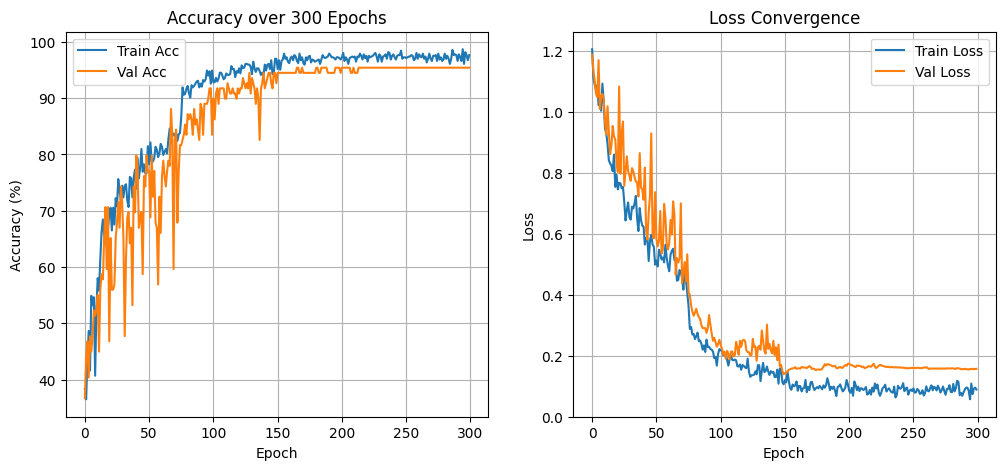

In [24]:
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
EPOCHS = 300
SAVE_INTERVAL = 50  # Save backup every 50 epochs
start_time = time.time()

print(f"--- Starting Full 300-Epoch Training (IQ-OTH/NCCD) ---")
print(f"Device: {DEVICE}")

# 1. Initialize Fresh Model
model = HybridLungCancerModel(num_classes=3).to(DEVICE)

# 2. Optimizer & Scheduler (Adjusted for long training)
# Paper uses SGD with Momentum 0.9 and Weight Decay 2.0e-05 [cite: 505]
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-5)

# Decay LR by 10% every 75 epochs (Suitable for a 300 epoch run)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.1)

# 3. Weighted Loss (Crucial for Imbalance)
if 'class_weights_tensor' in locals():
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print("-> Using Weighted Loss.")
else:
    criterion = nn.CrossEntropyLoss()
    print("-> Warning: Standard Loss (No Weights).")

# Arrays to store history for plotting later
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

# --- TRAINING LOOP ---
for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(model, iq_train, criterion, optimizer)

    # Validate
    val_loss, val_acc = validate(model, iq_val, criterion)

    # Update Scheduler
    scheduler.step()

    # Store Stats
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_iq_model_300epochs.pth')
        saved_msg = "-> BEST Saved!"
    else:
        saved_msg = ""

    # Safety Checkpoint (Every 50 Epochs)
    if (epoch + 1) % SAVE_INTERVAL == 0:
        torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pth')
        print(f"   [Checkpoint Saved at Epoch {epoch+1}]")

    # Print Update
    # We use a simpler print to avoid cluttering the screen over 300 lines
    if (epoch + 1) % 5 == 0: # Print only every 5 epochs to reduce output size
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}% {saved_msg}")

print(f"Training Complete. Best Accuracy: {best_acc:.2f}%")
print(f"Total Time: {(time.time() - start_time)/60:.2f} minutes")

# --- PLOT RESULTS FOR PAPER ---
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title(f'Accuracy over {EPOCHS} Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('training_curves_300epochs.png') # Save plot for your paper
plt.show()

--- Starting Full 300-Epoch Training (Chest CT - 4 Classes) ---
Calculating class weights...
Chest CT Weights: [0.7858974358974359, 1.3326086956521739, 1.035472972972973, 0.9887096774193549]
Epoch 5/300 | Loss: 1.0874 | Val Acc: 45.83% 
Epoch 10/300 | Loss: 0.8955 | Val Acc: 56.94% 
Epoch 15/300 | Loss: 0.9552 | Val Acc: 47.22% 
Epoch 20/300 | Loss: 0.8599 | Val Acc: 47.22% 
Epoch 25/300 | Loss: 0.8938 | Val Acc: 50.00% 
Epoch 30/300 | Loss: 0.8116 | Val Acc: 41.67% 
Epoch 35/300 | Loss: 0.7800 | Val Acc: 52.78% 
Epoch 40/300 | Loss: 0.7112 | Val Acc: 44.44% 
Epoch 45/300 | Loss: 0.5627 | Val Acc: 65.28% -> BEST Saved!
Epoch 50/300 | Loss: 0.7018 | Val Acc: 51.39% 
Epoch 55/300 | Loss: 0.8290 | Val Acc: 69.44% -> BEST Saved!
Epoch 60/300 | Loss: 0.6113 | Val Acc: 48.61% 
Epoch 65/300 | Loss: 0.4581 | Val Acc: 73.61% 
Epoch 70/300 | Loss: 0.4524 | Val Acc: 69.44% 
Epoch 75/300 | Loss: 0.4330 | Val Acc: 62.50% 
Epoch 80/300 | Loss: 0.2553 | Val Acc: 70.83% 
Epoch 85/300 | Loss: 0.2462 | 

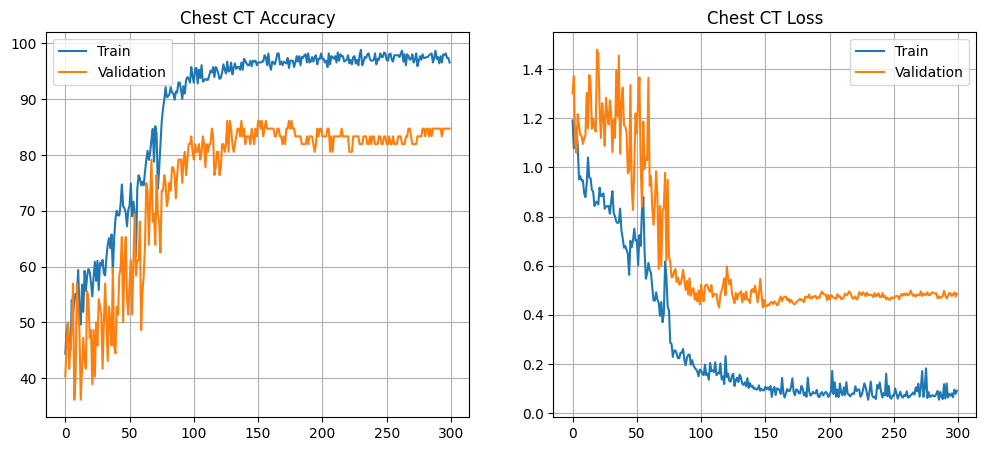

In [25]:
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
EPOCHS = 300
SAVE_INTERVAL = 50
print("--- Starting Full 300-Epoch Training (Chest CT - 4 Classes) ---")

# 1. Calculate Weights for Chest CT (Addressing Imbalance)
# We calculate this fresh to ensure no errors
def get_class_counts(loader, num_classes):
    counts = [0] * num_classes
    for _, labels in loader:
        for label in labels:
            counts[label.item()] += 1
    return counts

# Chest CT has 4 classes
print("Calculating class weights...")
# Note: We access the dataset directly if possible for speed, else iterate loader
chest_counts = get_class_counts(chest_train, 4)
total_chest = sum(chest_counts)
# Weight formula: Total / (Num_Classes * Count)
chest_weights = [total_chest / (4 * c) if c > 0 else 1.0 for c in chest_counts]
chest_weights_tensor = torch.tensor(chest_weights, dtype=torch.float).to(DEVICE)
print(f"Chest CT Weights: {chest_weights}")

# 2. Initialize FRESH Model (4 Classes)
model_chest = HybridLungCancerModel(num_classes=4).to(DEVICE)

# 3. Optimizer & Scheduler
optimizer_chest = optim.SGD(model_chest.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-5)
scheduler_chest = optim.lr_scheduler.StepLR(optimizer_chest, step_size=75, gamma=0.1)
criterion_chest = nn.CrossEntropyLoss(weight=chest_weights_tensor)

# 4. History Tracking
history_chest = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc_chest = 0.0
start_time = time.time()

# --- TRAINING LOOP ---
for epoch in range(EPOCHS):
    # Train
    model_chest.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # We use a simple loop without tqdm per batch to save console space for 300 epochs
    for images, labels in chest_train:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer_chest.zero_grad()
        outputs = model_chest(images)
        loss = criterion_chest(outputs, labels)
        loss.backward()
        optimizer_chest.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(chest_train)
    train_acc = 100 * correct / total

    # Validate
    model_chest.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in chest_val:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_chest(images)
            loss = criterion_chest(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_running_loss / len(chest_val)

    # Store
    history_chest['train_loss'].append(avg_train_loss)
    history_chest['train_acc'].append(train_acc)
    history_chest['val_loss'].append(avg_val_loss)
    history_chest['val_acc'].append(val_acc)

    scheduler_chest.step()

    # Save Best
    if val_acc > best_acc_chest:
        best_acc_chest = val_acc
        torch.save(model_chest.state_dict(), 'best_chest_model_300epochs.pth')
        saved_msg = "-> BEST Saved!"
    else:
        saved_msg = ""

    # Safety Checkpoint
    if (epoch + 1) % SAVE_INTERVAL == 0:
        torch.save(model_chest.state_dict(), f'chest_checkpoint_epoch_{epoch+1}.pth')

    # Print Update (Every 5 epochs)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% {saved_msg}")

print(f"Chest CT Training Complete. Best Accuracy: {best_acc_chest:.2f}%")
print(f"Total Time: {(time.time() - start_time)/60:.2f} minutes")

# --- PLOT RESULTS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_chest['train_acc'], label='Train')
plt.plot(history_chest['val_acc'], label='Validation')
plt.title('Chest CT Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_chest['train_loss'], label='Train')
plt.plot(history_chest['val_loss'], label='Validation')
plt.title('Chest CT Loss')
plt.legend()
plt.grid(True)

plt.savefig('chest_ct_training_curves.png')
plt.show()

In [28]:
import shutil
import os

drive_path = '/content/drive/MyDrive/LungCancer_Project/'

# Backup the Chest CT Model
if os.path.exists('best_chest_model_300epochs.pth'):
    shutil.copy('best_chest_model_300epochs.pth', drive_path + 'best_chest_model_300epochs.pth')
    print(f"-> Chest CT Model backed up to {drive_path}")

# Backup the Training Curves (Images)
if os.path.exists('chest_ct_training_curves.png'):
    shutil.copy('chest_ct_training_curves.png', drive_path + 'chest_ct_training_curves.png')
    print("-> Training curves image backed up.")

-> Chest CT Model backed up to /content/drive/MyDrive/LungCancer_Project/
-> Training curves image backed up.



Generating Grad-CAM for Chest CT Model... (/content/drive/MyDrive/LungCancer_Project/best_chest_model_300epochs.pth)


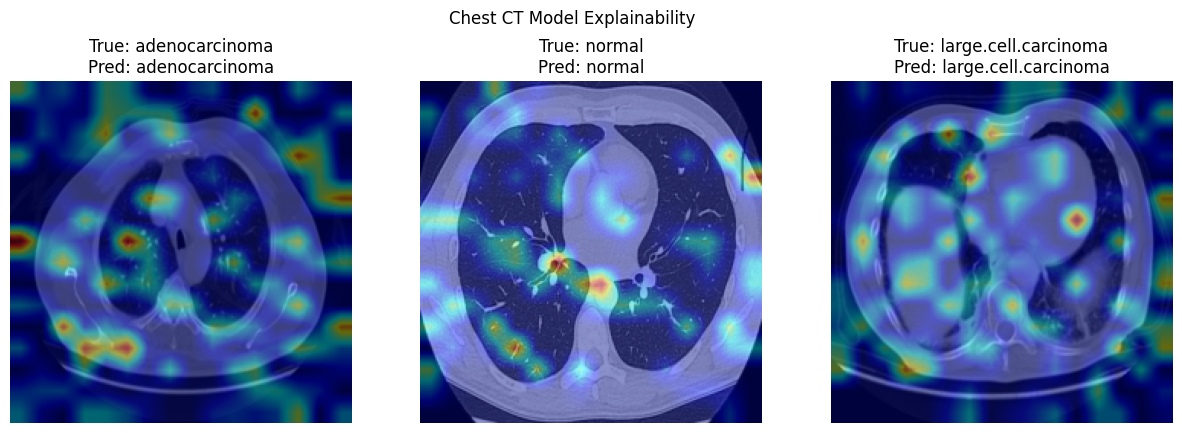

In [30]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive_path = '/content/drive/MyDrive/LungCancer_Project/'

# --- MODEL DEFINITION (Must match your training exactly) ---
class InceptionDWConv2d(nn.Module):
    def __init__(self, in_channels, square_kernel_size=3, band_kernel_size=11, branch_ratio=0.125):
        super().__init__()
        gc = int(in_channels * branch_ratio)
        self.dwconv_hw = nn.Conv2d(gc, gc, square_kernel_size, padding=square_kernel_size//2, groups=gc)
        self.dwconv_w = nn.Conv2d(gc, gc, (1, band_kernel_size), padding=(0, band_kernel_size//2), groups=gc)
        self.dwconv_h = nn.Conv2d(gc, gc, (band_kernel_size, 1), padding=(band_kernel_size//2, 0), groups=gc)
        self.split_indexes = (in_channels - 3 * gc, gc, gc, gc)

    def forward(self, x):
        x_id, x_hw, x_w, x_h = torch.split(x, self.split_indexes, dim=1)
        return torch.cat((x_id, self.dwconv_hw(x_hw), self.dwconv_w(x_w), self.dwconv_h(x_h)), dim=1)

class InceptionNextBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = InceptionDWConv2d(dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)
        return input + x

class SimpleAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(nn.Linear(dim, 4 * dim), nn.GELU(), nn.Linear(4 * dim, dim))

    def forward(self, x):
        n, c, h, w = x.shape
        x_flat = x.flatten(2).transpose(1, 2)
        x_norm = self.norm1(x_flat)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x_flat = x_flat + attn_out
        x_norm = self.norm2(x_flat)
        mlp_out = self.mlp(x_norm)
        x_flat = x_flat + mlp_out
        return x_flat.transpose(1, 2).reshape(n, c, h, w)

class HybridLungCancerModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.stem = nn.Sequential(nn.Conv2d(3, 64, 7, 2, 3), nn.BatchNorm2d(64), nn.ReLU(True), nn.MaxPool2d(3, 2, 1))
        self.stage1 = nn.Sequential(InceptionNextBlock(64), InceptionNextBlock(64))
        self.downsample1 = nn.Conv2d(64, 128, 3, 2, 1)
        self.stage2 = nn.Sequential(InceptionNextBlock(128), InceptionNextBlock(128))
        self.downsample2 = nn.Conv2d(128, 256, 3, 2, 1)
        self.stage3 = nn.Sequential(InceptionNextBlock(256), SimpleAttentionBlock(256))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.downsample1(x)
        x = self.stage2(x)
        x = self.downsample2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

# --- HELPER: GRAD-CAM GENERATOR ---
def generate_heatmap(model, img_tensor, target_layer):
    gradients = []
    activations = []
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    def forward_hook(module, input, output): activations.append(output)

    h1 = target_layer.register_full_backward_hook(backward_hook)
    h2 = target_layer.register_forward_hook(forward_hook)

    # Forward & Backward
    output = model(img_tensor)
    score, pred = torch.max(output, 1)
    model.zero_grad()
    score.backward()

    h1.remove()
    h2.remove()

    # Process Maps
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]

    # Reshape (Sequence -> Spatial)
    size = int(np.sqrt(grads.shape[1])) # Should be 14
    grads = grads.reshape(size, size, -1).transpose(2, 0, 1)
    fmap = fmap.reshape(size, size, -1).transpose(2, 0, 1)

    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
    return cam, pred.item()

# --- EXECUTE VISUALIZATION ---
# Update these to match your actual folders in Colab or Drive
iq_data_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'
chest_data_path = '/content/drive/MyDrive/Data'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 1. Visualize IQ Model
iq_model_path = os.path.join(drive_path, 'best_iq_model_300epochs.pth')
# Handle the (1) file rename issue if needed
if not os.path.exists(iq_model_path):
    iq_model_path = os.path.join(drive_path, 'best_iq_model_300epochs (1).pth')

if os.path.exists(iq_model_path):
    print(f"Generating Grad-CAM for IQ Model... ({iq_model_path})")
    model = HybridLungCancerModel(num_classes=3).to(DEVICE)
    model.load_state_dict(torch.load(iq_model_path, map_location=DEVICE))
    model.eval()

    try:
        ds = datasets.ImageFolder(iq_data_path, transform=transform)
        # Pick 3 random images
        indices = np.random.choice(len(ds), 3, replace=False)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, idx in enumerate(indices):
            img, label = ds[idx]
            img_tensor = img.unsqueeze(0).to(DEVICE)
            heatmap, pred = generate_heatmap(model, img_tensor, model.stage3[1].norm2)

            # Overlay
            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            heatmap_c = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
            heatmap_c = cv2.cvtColor(heatmap_c, cv2.COLOR_BGR2RGB) / 255.0
            overlay = 0.6 * img_np + 0.4 * heatmap_c

            axes[i].imshow(overlay)
            axes[i].set_title(f"True: {ds.classes[label]}\nPred: {ds.classes[pred]}")
            axes[i].axis('off')

        plt.suptitle("IQ-OTH/NCCD Model Explainability")
        plt.savefig('gradcam_iq_final.png')
        plt.show()
    except Exception as e:
        print(f"Skipping IQ Viz (Data issue): {e}")

# 2. Visualize Chest CT Model
chest_model_path = os.path.join(drive_path, 'best_chest_model_300epochs.pth')

if os.path.exists(chest_model_path):
    print(f"\nGenerating Grad-CAM for Chest CT Model... ({chest_model_path})")
    model = HybridLungCancerModel(num_classes=4).to(DEVICE)
    model.load_state_dict(torch.load(chest_model_path, map_location=DEVICE))
    model.eval()

    try:
        # Try to find test folder, else use root
        root = os.path.join(chest_data_path, 'test')
        if not os.path.exists(root): root = chest_data_path

        ds = datasets.ImageFolder(root, transform=transform)
        indices = np.random.choice(len(ds), 3, replace=False)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, idx in enumerate(indices):
            img, label = ds[idx]
            img_tensor = img.unsqueeze(0).to(DEVICE)
            heatmap, pred = generate_heatmap(model, img_tensor, model.stage3[1].norm2)

            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            heatmap_c = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
            heatmap_c = cv2.cvtColor(heatmap_c, cv2.COLOR_BGR2RGB) / 255.0
            overlay = 0.6 * img_np + 0.4 * heatmap_c

            axes[i].imshow(overlay)
            axes[i].set_title(f"True: {ds.classes[label]}\nPred: {ds.classes[pred]}")
            axes[i].axis('off')

        plt.suptitle("Chest CT Model Explainability")
        plt.savefig('gradcam_chest_final.png')
        plt.show()
    except Exception as e:
        print(f"Skipping Chest Viz (Data issue): {e}")

Data loaded. Classes: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Running predictions on test set...


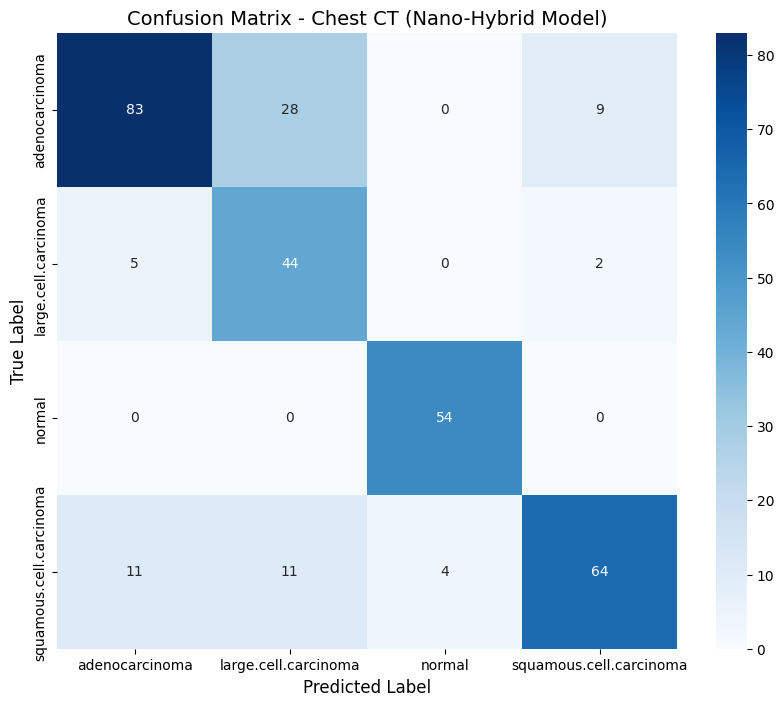

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from torchvision import datasets, transforms

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Update this path to where your Chest CT 'test' folder is
test_dir = '/content/drive/MyDrive/Data/test'
model_path = '/content/drive/MyDrive/LungCancer_Project/best_chest_model_300epochs.pth'

# Define Transforms (Must match training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data
try:
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    class_names = test_dataset.classes
    print(f"Data loaded. Classes: {class_names}")

    # Load Model
    model = HybridLungCancerModel(num_classes=4).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    # Get Predictions
    all_preds = []
    all_labels = []
    print("Running predictions on test set...")
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Generate Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - Chest CT (Nano-Hybrid Model)', fontsize=14)
    plt.savefig('confusion_matrix_chest.png')
    plt.show()

except FileNotFoundError:
    print(f"Error: Check your paths. Could not find data at {test_dir} or model at {model_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Generating ROC Curves...


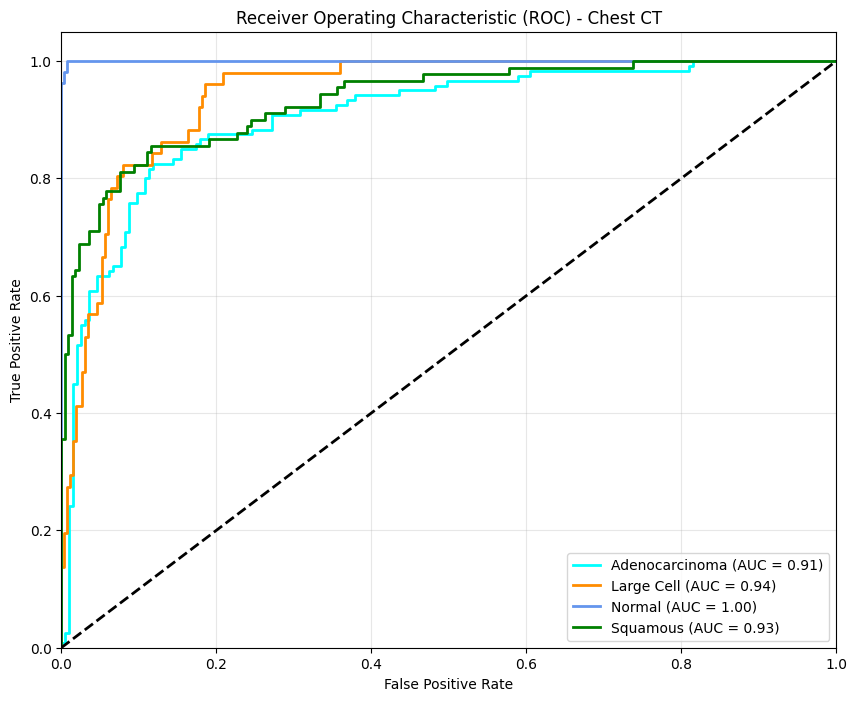

Generating Efficiency Comparison...


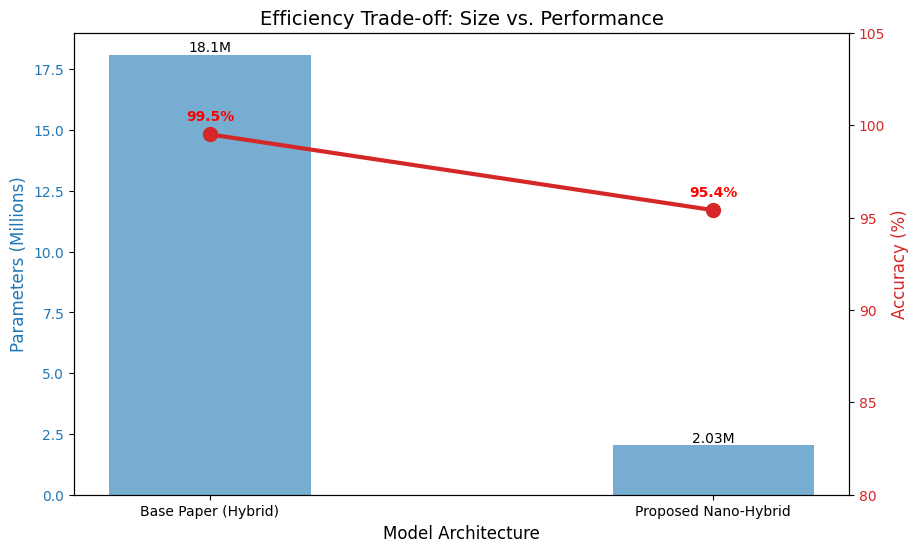

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import torch
from torchvision import datasets, transforms

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chest_test_path = '/content/drive/MyDrive/Data/test'
chest_model_path = '/content/drive/MyDrive/LungCancer_Project/best_chest_model_300epochs.pth'

# --- 1. GENERATE ROC CURVES ---
def plot_roc_curves():
    print("Generating ROC Curves...")

    # Load Data & Model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    dataset = datasets.ImageFolder(chest_test_path, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

    model = HybridLungCancerModel(num_classes=4).to(DEVICE)
    model.load_state_dict(torch.load(chest_model_path, map_location=DEVICE))
    model.eval()

    # Get Probabilities (Softmax)
    y_score = []
    y_test = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            y_score.extend(probs.cpu().numpy())
            y_test.extend(labels.numpy())

    y_score = np.array(y_score)
    y_test = np.array(y_test)

    # Binarize labels for multi-class ROC
    n_classes = 4
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    class_names = ['Adenocarcinoma', 'Large Cell', 'Normal', 'Squamous']

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Chest CT')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig('roc_curves_chest.png')
    plt.show()

# --- 2. GENERATE EFFICIENCY COMPARISON PLOT ---
def plot_efficiency():
    print("Generating Efficiency Comparison...")

    # Data points
    models = ['Base Paper (Hybrid)', 'Proposed Nano-Hybrid']
    params = [18.1, 2.03]   # Millions of Parameters
    accuracy = [99.5, 95.4] # Accuracy on IQ Dataset (%)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for Parameters (Size)
    color = 'tab:blue'
    ax1.set_xlabel('Model Architecture', fontsize=12)
    ax1.set_ylabel('Parameters (Millions)', color=color, fontsize=12)
    bars = ax1.bar(models, params, color=color, alpha=0.6, width=0.4, label='Model Size')
    ax1.tick_params(axis='y', labelcolor=color)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}M', ha='center', va='bottom')

    # Line chart for Accuracy
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Accuracy (%)', color=color, fontsize=12)
    ax2.plot(models, accuracy, color=color, marker='o', linewidth=3, markersize=10, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(80, 105) # Scale to make the difference look reasonable

    # Add accuracy labels
    for i, txt in enumerate(accuracy):
        ax2.annotate(f"{txt}%", (models[i], accuracy[i]),
                     xytext=(0, 10), textcoords='offset points', ha='center', color='red', fontweight='bold')

    plt.title('Efficiency Trade-off: Size vs. Performance', fontsize=14)
    plt.savefig('efficiency_comparison.png')
    plt.show()

# Execute
try:
    plot_roc_curves()
    plot_efficiency()
except Exception as e:
    print(f"Error generating visuals: {e}")

Generating Visuals for IQ Dataset...
Classes found: ['Bengin cases', 'Malignant cases', 'Normal cases']
Total Images: 1097 | Test Set Size: 111


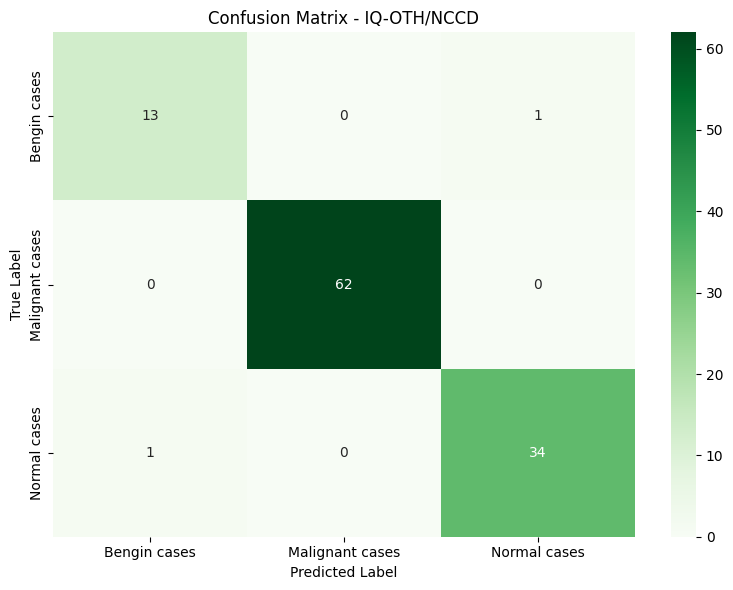

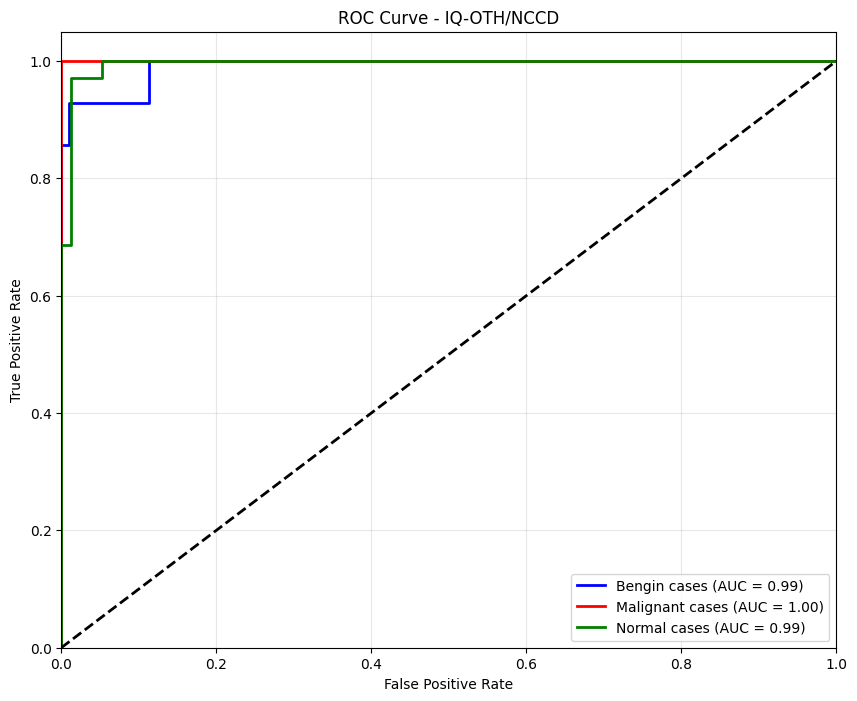

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# POINT THIS TO THE MAIN ROOT FOLDER (containing Benign, Malignant, Normal)
# Example: '/content/drive/MyDrive/LungCancer_Project/IQ-OTH-NCCD'
iq_root_path = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

# Path to your saved model
iq_model_path = 'best_iq_model_300epochs.pth'
if not os.path.exists(iq_model_path):
    iq_model_path = 'best_iq_model_300epochs.pth'

print(f"Generating Visuals for IQ Dataset...")

# --- SETUP ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    # 1. Load the WHOLE dataset
    full_dataset = datasets.ImageFolder(iq_root_path, transform=transform)
    class_names = full_dataset.classes
    print(f"Classes found: {class_names}")

    # 2. Split it (Same logic as training: 80% Train, 10% Val, 10% Test)
    # We need to recreate the split to ensure we test on unseen data
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Use a fixed seed generator so the split is reproducible
    generator = torch.Generator().manual_seed(42)
    _, _, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

    print(f"Total Images: {total_size} | Test Set Size: {len(test_dataset)}")

    # Create Loader for just the Test portion
    loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 3. Load Model
    model = HybridLungCancerModel(num_classes=3).to(DEVICE)
    model.load_state_dict(torch.load(iq_model_path, map_location=DEVICE))
    model.eval()

    # 4. Run Predictions
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # --- VISUAL 1: CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - IQ-OTH/NCCD')
    plt.tight_layout()
    plt.savefig('confusion_matrix_iq.png')
    plt.show()

    # --- VISUAL 2: ROC CURVE ---
    n_classes = 3
    y_test_bin = label_binarize(all_labels, classes=[0, 1, 2])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - IQ-OTH/NCCD')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig('roc_curve_iq.png')
    plt.show()

except Exception as e:
    print(f"Error: {e}")